In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Let's train the model again first - to use its results later in this notebook

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

In [89]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
len(y_val)

1409

In [90]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [91]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [8]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [92]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [10]:
y_pred

array([0.00714988, 0.20938562, 0.21964152, ..., 0.15036391, 0.78267557,
       0.81080168], shape=(1409,))

In [11]:
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

## **Accuracy**

- Evaluate the model on different thresholds
- check the accuracy of dummy baselines

Accuracy asks the question - is 80%, ie np.float64(0.8016129032258065) above, sufficient?

In [12]:
len(y_val)


1409

In [13]:
(churn_decision == y_val).sum()

np.int64(1135)

In [14]:
# Accuracy, no of correct predictions divided by the total no. of customers.

1135/1409

# ie (churn_decision == y_val).mean() = 0.8055...

0.8055358410220014

##### **Threshold** 

The threshold determines the cutoff value for converting predicted probabilities into binary class predictions.

* By default we used 0.5, but is it actually the best.
  
If y_pred >= threshold, predict class 1 (churn).
If y_pred < threshold, predict class 0 (no churn).


By changing the threshold, you control how sensitive your model is to predicting the positive class.
A threshold of 0.5 is standard, but you can adjust it to balance precision and recall for your use case

In [15]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f, %.3f' % (t, score))
    scores.append(score)

#Here, score means the accuracy.

0.00, 0.274
0.05, 0.510
0.10, 0.607
0.15, 0.663
0.20, 0.705
0.25, 0.735
0.30, 0.759
0.35, 0.768
0.40, 0.781
0.45, 0.791
0.50, 0.806
0.55, 0.801
0.60, 0.798
0.65, 0.785
0.70, 0.767
0.75, 0.742
0.80, 0.729
0.85, 0.726
0.90, 0.726
0.95, 0.726
1.00, 0.726


Here, we see that the threshold of 0.5, gives the best accuracy score

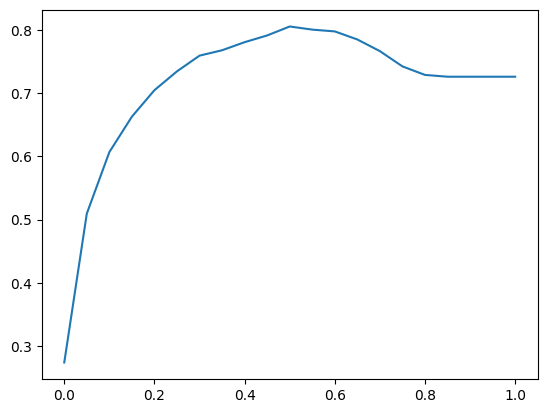

In [16]:
plt.plot(thresholds, scores)

**Similarly, we can use scikit-learn to complete the accuracy scores over diffferent thresholds.**

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
accuracy_score(y_val,y_pred>= 0.5)

0.8055358410220014

In [19]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val,y_pred >= t)
    print('%.2f, %.3f' % (t, score))
    scores.append(score)


0.00, 0.274
0.05, 0.510
0.10, 0.607
0.15, 0.663
0.20, 0.705
0.25, 0.735
0.30, 0.759
0.35, 0.768
0.40, 0.781
0.45, 0.791
0.50, 0.806
0.55, 0.801
0.60, 0.798
0.65, 0.785
0.70, 0.767
0.75, 0.742
0.80, 0.729
0.85, 0.726
0.90, 0.726
0.95, 0.726
1.00, 0.726


In [20]:
from collections import Counter

In [21]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

Our model at t = 0.5, shows 80% accuracy, but the model at t = 1.0, which suggests every customer churns is 73%, so why bother, if there's 7% difference btw the models?

In [22]:
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

In [23]:
# y_val.mean()
#shows that 27% are churning. 

1 - y_val.mean() #shows that 73% are not churning in the real data.

#So checking model's threshold using accuracy scores matter because of the class imbalance,
# Just using a dummy model prediction of t=1.0, shows 73% accuracy for churning [1.00, 0.726] which is deceitful, due to class imbalance
#Check explanations for class imbalance online. 

np.float64(0.7260468417317246)

## Confusion tables

- Different types of errors and correct decisions
- Arranging positives and negatives in a table

In [24]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [25]:
t = 0.5

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [26]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()


In [27]:
fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [28]:
# so confusion table puts the 4 aspects into a matrix:

confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[921, 102],
       [172, 214]])

- Remember, the false negatives, we make error in not identifying them as actual positive churn,
- so we errorneously dont send them the needed marketing emails to retain them and hence they leave.
- for the false positives, we mistakenly send them email ads eventhough they are not gonna churn. so again we spend unnecessary money.

In [29]:
#we can also get the rates from the confusion matrix

(confusion_matrix / confusion_matrix .sum()).round(2)

#we see, we only get 65% accuracy for no churn (TN), and just 15% accuracy for churn (TP)


array([[0.65, 0.07],
       [0.12, 0.15]])

## Precision and Recall

- Precision: tells how many fractions of positive/correct predictions (TP) among all positive predictions (TP + FP).
- Recall; The recall of a model is the fraction of correctly predicted churning customers (TP) among all customers who churned (TP + FN)

In [30]:
p = tp / (tp + fp)
p

# Here, we have 33% of users who are not going to churn, but we incorrectly identified them as churning. 
# our precision in identifying correct predictions or churning is 67%.

np.float64(0.6772151898734177)

In [31]:
r = tp / (tp + fn)
r

# this means 45% of people who are churning we fail to identify them.
# Here, we are able to identify just 55% of all churned customers.

np.float64(0.5544041450777202)

### ROC AND AUC

ROC and AUC are metrics used to evaluate classification models, particularly in machine learning:
ROC (Receiver Operating Characteristic)
ROC is a curve that visualizes a classifier's performance across all classification thresholds. It plots:

- Y-axis: True Positive Rate (TPR) / Sensitivity / Recall = TP / (TP + FN)
- X-axis: False Positive Rate (FPR) = FP / (FP + TN)

As you adjust the classification threshold (the cutoff for predicting positive vs. negative), you get different TPR and FPR values, which creates the curve.
AUC (Area Under the Curve),

AUC is the area under the ROC curve - a single number summarizing the model's performance:

- Range: 0 to 1
- AUC = 0.5: Random guessing (diagonal line)
- AUC = 1.0: Perfect classifier
- AUC < 0.5: Worse than random (predictions are inverted)

**Why they're useful**

- Threshold-independent: Unlike accuracy, ROC/AUC evaluate performance across all possible thresholds
- Imbalanced data: More informative than accuracy when classes are imbalanced
- Model comparison: Easy to compare different models with a single number (AUC)

Example interpretation: An AUC of 0.85 means there's an 85% chance the model will rank a random positive example higher than a random negative 

In [32]:
tpr = tp / (tp + fn)
tpr

#tpr is also known as recall

np.float64(0.5544041450777202)

In [33]:
fpr = fp / (fp + tn)
fpr

np.float64(0.09970674486803519)

In [34]:
#Calc TPR and FPR

scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds: 
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()  #ie, ((y_pred >= t) & (y_val == 1)).sum()
    tn = (predict_negative & actual_negative).sum() #ie, ((y_pred < t) & (y_val == 0)).sum()
    
    fp = (predict_positive & actual_negative).sum() #ie, ((y_pred >= t) & (y_val == 0)).sum()
    fn = (predict_negative & actual_positive).sum() #ie, ((y_pred < t) & (y_val == 1)).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [35]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns = columns)

In [36]:
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,386,1023,0,0
10,0.1,366,534,20,489
20,0.2,338,368,48,655
30,0.3,293,246,93,777
40,0.4,253,176,133,847
50,0.5,214,102,172,921
60,0.6,152,51,234,972
70,0.7,69,12,317,1011
80,0.8,4,0,382,1023
90,0.9,0,0,386,1023


In [37]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [38]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,534,20,489,0.948187,0.521994
20,0.2,338,368,48,655,0.875648,0.359726
30,0.3,293,246,93,777,0.759067,0.240469
40,0.4,253,176,133,847,0.655440,0.172043
50,0.5,214,102,172,921,0.554404,0.099707
60,0.6,152,51,234,972,0.393782,0.049853
70,0.7,69,12,317,1011,0.178756,0.011730
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


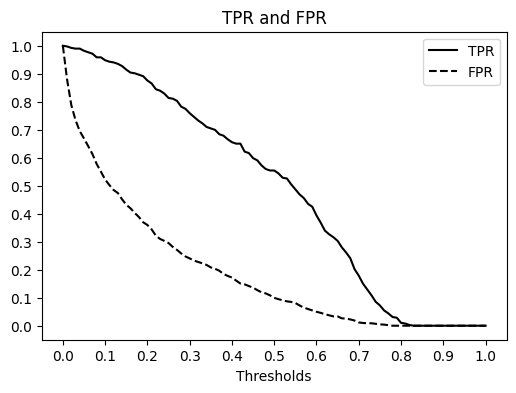

In [39]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR')

# plt.savefig('04_fpr_tpr_plot.svg')  [this saves the image to your computer)

plt.show()

To better understand, TPR and FPR, lets compare it against two baseline models 
- Random and,
- Ideal
  

## **Random model**

In [40]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size = len(y_val))

# here, we assign every customer in validation dataset, a random number between 0 and 1, which assumes a uniform distribution.

In [41]:
((y_rand >= 0.5) == y_val).mean()

#accuracy of the model is about 50%. just by luck. at the t >=0.5

np.float64(0.5017743080198722)

In [42]:
#Calc TPR and FPR
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds: 
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()  #ie, ((y_pred >= t) & (y_val == 1)).sum()
        tn = (predict_negative & actual_negative).sum() #ie, ((y_pred < t) & (y_val == 0)).sum()
        
        fp = (predict_positive & actual_negative).sum() #ie, ((y_pred >= t) & (y_val == 0)).sum()
        fn = (predict_negative & actual_positive).sum() #ie, ((y_pred < t) & (y_val == 1)).sum()
        
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns = columns)
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [43]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [44]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


Text(0.5, 1.0, 'TPR and FPR')

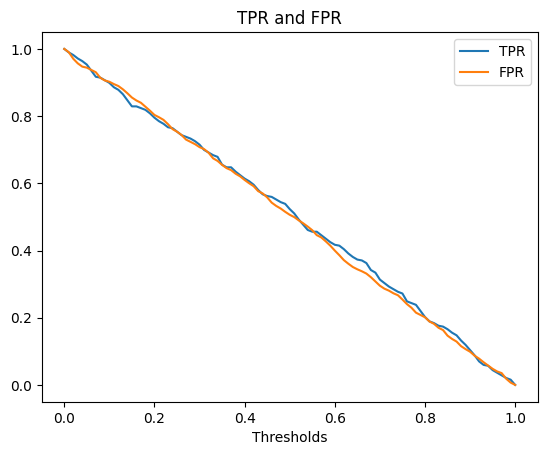

In [45]:
plt.plot(df_rand.threshold, df_rand.tpr, label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label='FPR')
plt.legend()

plt.xlabel('Thresholds')
plt.title('TPR and FPR')

## **Ideal model**

In [46]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [47]:
y_ideal = np.repeat([0,1], [num_neg,num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1], shape=(1409,))

In [48]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [49]:
((y_ideal_pred >= 0.726) == y_ideal).mean()  #NB, we noticed that from the accuracy scores prediction of y_val,y_pred gave us 72.6% at 1.0 threshold.

np.float64(1.0)

In [50]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [51]:
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


Text(0.5, 1.0, 'TPR and FPR')

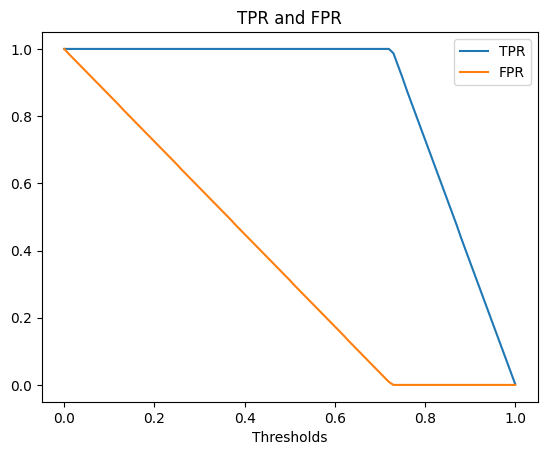

In [52]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

plt.xlabel('Thresholds')
plt.title('TPR and FPR')


## Putting the models together

Text(0.5, 1.0, 'TPR and FPR')

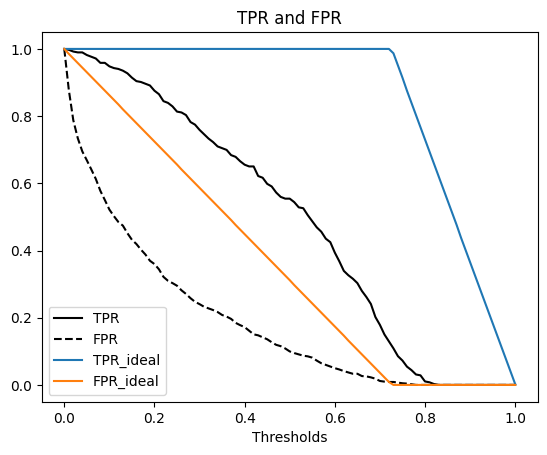

In [53]:
plt.plot(df_scores.threshold, df_scores.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, color='black', linestyle='dashed', label='FPR')

#plt.plot(df_rand.threshold, df_rand.tpr, label='TPR_rand')
#plt.plot(df_rand.threshold, df_rand.fpr, label='FPR_rand')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR_ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR_ideal')
plt.legend()

plt.xlabel('Thresholds')
plt.title('TPR and FPR')


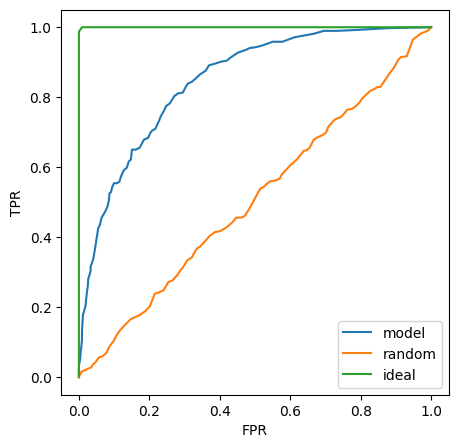

In [54]:
plt.figure(figsize =(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label = 'model')
plt.plot(df_rand.fpr, df_rand.tpr, label = 'random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label = 'ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

### For a  ROC curve.

- It shows the relationship between the FPR and TPR of a model

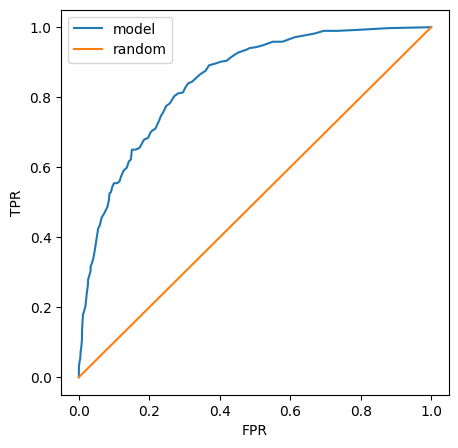

In [55]:
plt.figure(figsize =(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label = 'model')
plt.plot([0,1],[0,1], label = 'random')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

### **Implementation with scikit_learn**

In [56]:
from sklearn.metrics import roc_curve

In [57]:
fpr, tpr, thresholds = roc_curve(y_val,y_pred)

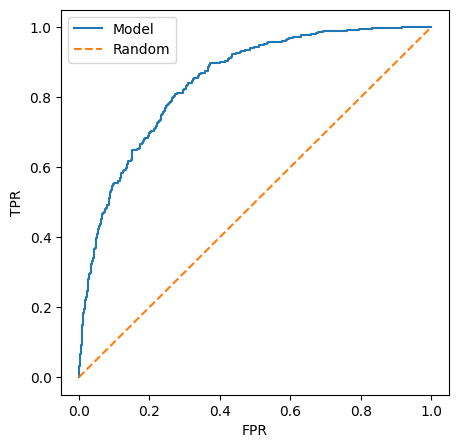

In [58]:
plt.figure(figsize =(5,5))

plt.plot(fpr, tpr, label = 'Model')
plt.plot([0,1],[0,1], label = 'Random', linestyle = '--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

## **ROC AUC**

- Area under the ROC curve; useful metric for evaluating the ROC and ideal point
- we want the curve to be close to the ideal spot but as far from the random baseline as possible.- 

In [59]:
from sklearn.metrics import auc

In [60]:
auc(fpr,tpr)

0.8464234523067885

In [61]:
auc(df_scores.fpr, df_scores.tpr)

0.8462411175097118

In [62]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [63]:
fpr, tpr, thresholds = roc_curve(y_val,y_pred)
auc(fpr, tpr)

0.8464234523067885

In [119]:
from sklearn.metrics import roc_auc_score

In [120]:
roc_auc_score(y_val,y_pred) #short cut to test it on model

0.8426677307512593

AUC is basically the probability that a randomly selected positive example (churn) has a score that is greater than a randomly chosen negative (no churn) example. 

In [66]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [67]:
import random

In [68]:
n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84735

In [69]:
n = 50000

pos_ind = np.random.randint(0, len(pos), size = n)
neg_ind = np.random.randint(0, len(neg), size = n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.8477)

## **Cross-validation and parameter tuning**

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

- Parameter tuning, the process of selecting the best parameter for training the model.
- By **K-fold cross validation**, we use all availablbe data to assess the quality of the models and get reliable results. Hence, we  can perform the validation multiple times across several datapoints
  

In [132]:
def train(df_train, y_train, C = 1.0):   #default value of c = 1.0
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train =dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', max_iter=1000, C=C)
    model.fit(X_train,y_train)

    return dv, model

In [133]:
dv, model = train(df_train, y_train, C= 0.001)

In [134]:
def predict(df, dv, model):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [81]:
y_pred = predict(df_val, dv, model)

In [83]:
from sklearn.model_selection import KFold

In [84]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [94]:
kfold.split(df_train_full)

<generator object _BaseKFold.split at 0x7be7aa14a130>

In [96]:
train_idx, val_idx = next(kfold.split(df_train_full))

In [98]:
len(train_idx), len(val_idx),len(df_train_full)

(5070, 564, 5634)

In [ ]:
df_train = df_train_full.iloc[train_idx]
df_val = df_train_full.iloc[val_idx]

In [101]:
!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [114]:
from tqdm.auto import tqdm #used to show progress of computation

In [130]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)

    scores = []
    
    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]
    
        y_train = df_train.churn.values
        y_val = df_train.churn.values
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.826 +- 0.002
C=0.01 0.843 +- 0.001
C=0.1 0.845 +- 0.002
C=0.5 0.846 +- 0.001
C=1 0.846 +- 0.001
C=5 0.846 +- 0.001
C=10 0.846 +- 0.001


In [137]:
# training the final model,
def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred
    
dv, model = train(df_train_full, df_train_full.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)

auc

0.8579400803839363

In [138]:
print(f"df_test shape: {df_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_pred shape: {y_pred.shape}")

df_test shape: (1409, 20)
y_test shape: (1409,)
y_pred shape: (1409,)


NB;


In the predict() function, we're using df_train instead of the df parameter that's passed in.

def predict(df, dv, model):
    dicts = df_train[categorical + numerical].to_dict(orient='records')   # ❌ WRONG - using df_train
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred
    
**This means every time we call predict(), it's always predicting on df_train (which has 5071 samples) regardless of what dataframe passed in!**

Fix:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')    # ✅ Use df parameter
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred